
# **Graded Notebook 2025**

#### **Dataset information**
We will use the **Health Insurance Costs** dataset (`insurance.csv`). Each row describes a person's demographic information (age, sex, BMI, number of children, region, smoker status) and the medical charges billed by an insurance company.

Download the dataset here: [insurance.csv](https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv) and save it in the same directory as this notebook.

**Focus:** Scoring prioritizes how well you *interpret* and communicate the results (plots, coefficients, errors, and caveats). Raw accuracy is secondary. Use markdown cells to explain what the numbers mean in plain language.


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans





---
## **Task 1: Explore and prepare the data (15 points)**

#### **1.1: Load and inspect (5 points)**
- Load `insurance.csv` and display the head, shape, and data types.
- Identify the meaning of each column and which are categorical vs. numerical, note any immediate quirks you observe (e.g., units, obvious outliers).
- Which column is likely to be your target? Why?


In [67]:
# Task 1.1
insurance_frame = pd.DataFrame(pd.read_csv("insurance.csv"))

print("===> dataset first 5 rows <===\n")
print(insurance_frame.head())

print("\n===> dataset shape <===\n")
print(insurance_frame.shape)

print("\n===> dataset data types <===\n")
print(insurance_frame.dtypes)

print("\n===> dataset description <===\n")
print(insurance_frame.describe())

print("\n==> dataset unique values (by column) <===\n")
print(insurance_frame.nunique())

===> dataset first 5 rows <===

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

===> dataset shape <===

(1338, 7)

===> dataset data types <===

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

===> dataset description <===

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     

# Observations
Categorical columns:
- sex (2 values)
- smoker (2 values)
- region (4 values)

Numerical columns:
- age (lowest is 18, highest 64. Average age is ~39, most people between 25 - 53)
- bmi (lowest is 15,96 (underweight), highest 53,13 (severely obese). Average BMI is 30,66, most people between 24,56 - 36,76)
- children (lowest count is 0, highest is 5. Average count is 1 child / person, most have between 0 - 2)
- charges (lowest charges are 1121,87, highest are 63770,43 (very large range). Average charges are 13270,42, most people have between 0 - 37,490)

Actually, the STD range for charges is between -10,950 - 37,490. Due to there being a huge range in charges, it's causing the lower value to dip into the negative, but that doesn't make any sense in real life. From the numerical columns, charges is a clear outlier due to the large range in values.

From the categorical values region stands out as an outlier. It contains twice as many values as the other two, one for each intermediate direction. It may be worth analysing if different regions have different costs.

## Charges is the best candidate for a target
All the other values are more like predictors, and a prediction of a person's medical costs would be a useful prediction to make for insurance companies.



#### **1.2: Understand distributions and relationships (10 points)**
- Visualize distributions and explore relationships between the features and the target.
- Summarize 2–3 hypotheses about which factors likely drive costs and why.

Plot 1


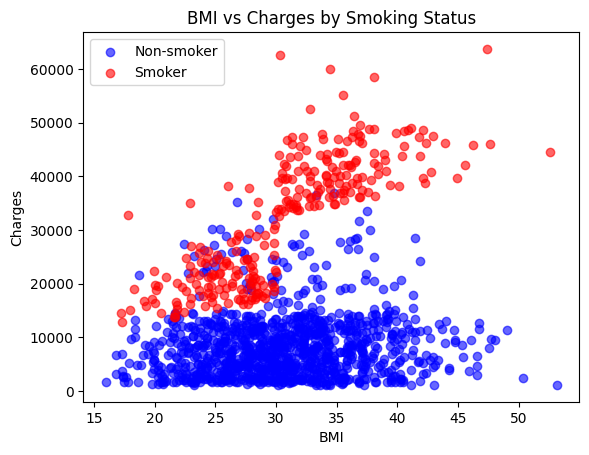

Plot 2


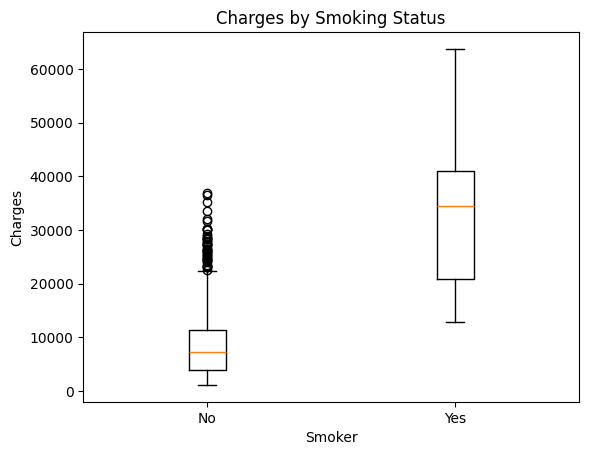

Plot 3


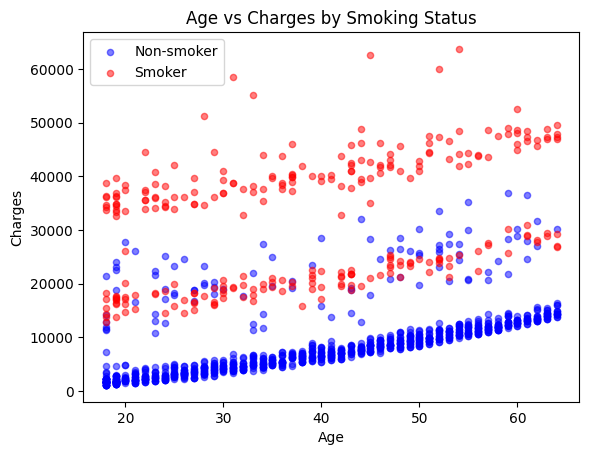

Plot 4


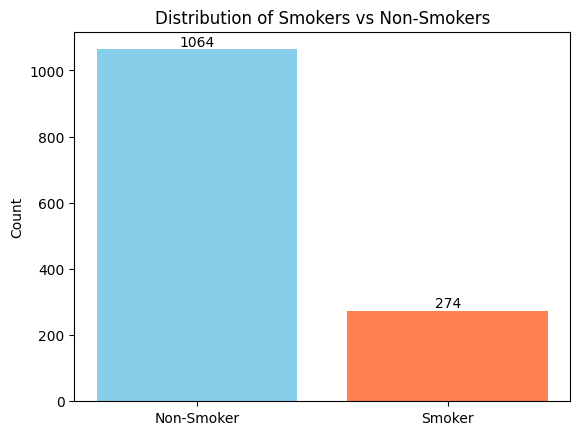

In [68]:
# Task 1.2

print("Plot 1")
# Separate the data into smokers and non-smokers
smokers = insurance_frame[insurance_frame["smoker"] == "yes"]
non_smokers = insurance_frame[insurance_frame["smoker"] == "no"]

# Plot each group with different colors
plt.scatter(non_smokers["bmi"], non_smokers["charges"], 
            alpha=0.6, label="Non-smoker", color="blue")
plt.scatter(smokers["bmi"], smokers["charges"], 
            alpha=0.6, label="Smoker", color="red")

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("BMI vs Charges by Smoking Status")
plt.legend()
plt.show()

print("Plot 2")
# Box plot for smoker vs charges
smoker_data = [
    insurance_frame[insurance_frame["smoker"] == "no"]["charges"],
    insurance_frame[insurance_frame["smoker"] == "yes"]["charges"]
]

plt.boxplot(smoker_data, tick_labels=["No", "Yes"])
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.title("Charges by Smoking Status")
plt.show()

print("Plot 3")
smokers = insurance_frame[insurance_frame["smoker"] == "yes"]
non_smokers = insurance_frame[insurance_frame["smoker"] == "no"]

plt.scatter(non_smokers["age"], non_smokers["charges"], 
            alpha=0.5, label="Non-smoker", color="blue", s=20)
plt.scatter(smokers["age"], smokers["charges"], 
            alpha=0.5, label="Smoker", color="red", s=20)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Age vs Charges by Smoking Status")
plt.legend()
plt.show()

print("Plot 4")
smoker_counts = insurance_frame["smoker"].value_counts()

bars = plt.bar(["Non-Smoker", "Smoker"], 
               [smoker_counts["no"], smoker_counts["yes"]], 
               color=["skyblue", "coral"])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.ylabel("Count")
plt.title("Distribution of Smokers vs Non-Smokers")
plt.show()

# Observations

## Hypothesis 1: Smokers will have increased medical charges
From plots 1-3 we can clearly see that higher medical charges are directly linked to being a smoker. Most people in the dataset are not smokers, and have medical charges below 15 000. Smokers, on the other hand, do not have medical charges below 10 000. Non-smokers do not typically incur this level of cost until they are >= 50 years old, while smokers can exceed it before they're 20.

Due to the negative effects on a person's health smoking cause, it is not surprising to see it have an effect on medical charges.

## Hypothesis 2: The older you are, the higher your medical charges will be
As we can see from plot 3, as a person's age increases, so too do their medical charges. Each distinct group of peoples' medical charges curve upward as their age increases.

As a person ages, they are more likely to develop more severe illnesses. Cancer, for example, can take decades to develop. This leads to it being more prevalent in older people.

## Hypothesis 3: Higher BMI will lead to increased medical charges
This seems to be true, but it is as not as pronounced of an effect as with the other two predictors, smoking status & age. However as is visible in plot 1, it seems that if a smoker has a higher BMI, it does lead to a stronger effect on incurring higher medical charges.

A higher BMI may be making existing health problems, for example ones causeed by smoking, to be worsened, leading to higher medical charges.

### Three most effective predictors
Smoker, Age, BMI.



---
## **Task 2: Regression – Predict medical charges (30 points)**

#### **2.1: Baseline linear models (15 points)**
- Using the features of your choice (likely linked to your hypothesis above), build a linear regression model to predict your target. Be mindful about the encoding of categorical values.
- Evaluate with at least two metrics and interpret their individual meaning.
- Interpret the sign and relative magnitude of coefficients linked to each feature in the model: what do they suggest about the link between each feature and the target?


R² Score: 0.7836
RMSE: 5796.28
MAE: 4181.19


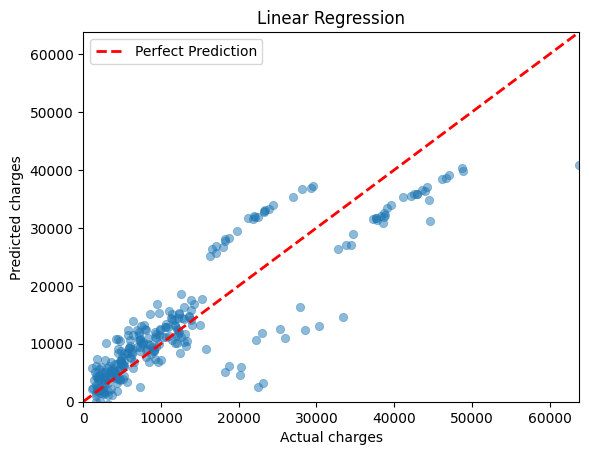

In [69]:
# Task 2.1
encoded_insurance = pd.get_dummies(insurance_frame, columns=["sex", "smoker", "region"], drop_first=True)

X = encoded_insurance.drop("charges", axis=1)
y = encoded_insurance["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train,y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


plt.scatter(y_test, y_pred_test, alpha=0.5, linewidth=0.5)
lims = [0, max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, "r--", lw=2, label="Perfect Prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Linear Regression")
plt.legend()
plt.show()

From the print outputs, we can see we have an R2 score of ~78%, meaning with the predictors we have, our model explains 78% of variance in charges. Pretty good, but could be better.

Our RMSE tells us on average, our prediction is off by just under 6 000. This is quite a lot, given the fact that the average charges is ~13 000, meaning our RMSE is just under half of the average amount of charges. Could be better.

Finally, our MAE is just over 4 000. In layman's terms, this means the average error of our predictions. It's another averaging metric, but is less sensitive to outliers (we have very high outliers) than RMSE.

Based on the plot, it seems like the relationship here may not be linear.

# Coefficients

In [70]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
})

# Sort by absolute magnitude (biggest impact first)
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(coef_df)
print(f"\nIntercept: {model.intercept_:,.2f}")

            Feature   Coefficient  Abs_Coefficient
4        smoker_yes  23651.128856     23651.128856
7  region_southwest   -809.799354       809.799354
6  region_southeast   -657.864297       657.864297
2          children    425.278784       425.278784
5  region_northwest   -370.677326       370.677326
1               bmi    337.092552       337.092552
0               age    256.975706       256.975706
3          sex_male    -18.591692        18.591692

Intercept: -11,931.22


# Observations

What we can see from the result here is that smoking is **by far** the strongest coefficient. Just being a smoker increases medical charges by nearly 23 700. We can also see BMI and & age being related to higher medical costs, but the amount of children is also increasing medical charges!

Northeast, the region not included in the training data, is the most expensive, with northwest being the second. From this we can conclude that healthcare costs are higher in the northern part of the country than the south.

There is also a very small difference in medical charges by gender, with men paying nearly 19 (whatever currency this is) less in medical charges.


#### **2.2: Improving metrics (15 points)**
- Try improving your results, one can chose one or more of the following methods:
    - Adding or removing some features
    - Transforming some features (e.g. polynomials)
    - Using another regression algorithm
- Are your results better? Why?


R²: 0.8708
RMSE: $4,479.18
            Feature  Importance
4        smoker_yes    0.649327
1               bmi    0.200544
0               age    0.128430
2          children    0.013545
5  region_northwest    0.002505
6  region_southeast    0.001928
7  region_southwest    0.001872
3          sex_male    0.001848


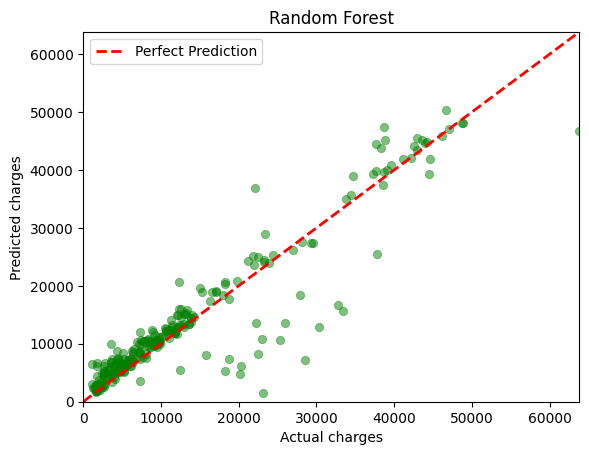

In [71]:
# Task 2.2
# doing a random forest because trees are cool

rf_model = RandomForestRegressor(
    n_estimators=100,      # tree number
    max_depth=10,          # tree depth
    min_samples_split=10,  # supposedly controls overfitting
    random_state=42,
    n_jobs=-1              # something about how many cpu cores are being used
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")

feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_imp)

plt.scatter(y_test, y_pred, alpha=0.5, linewidth=0.5, color="green")
lims = [0, max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, "r--", lw=2, label="Perfect Prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
plt.title("Random Forest")
plt.legend()
plt.show()

# Observations

Wow! Much better results!

We now have an R2 score of 87%, that's a 9% increase from the linear regression model.

Additionally, we have a RMSE 1 317 lower than the previous model. That's a 29.4% decrease.
As with the linear regression model, smokeer, bmi, age, and children are the most important predictors. Since the relationship may not be linear, the random forest is performing better.

## Let's try polynomial features on the linear model to see if we can't make it better

Original features: 8
After feature engineering: 16

New features created: 8

Results with Feature Engineering:
MAE: $2707.80
R²: 0.8700

Original MAE: $4161.19
Improvement: $1453.39
Percentage improvement: 34.93%


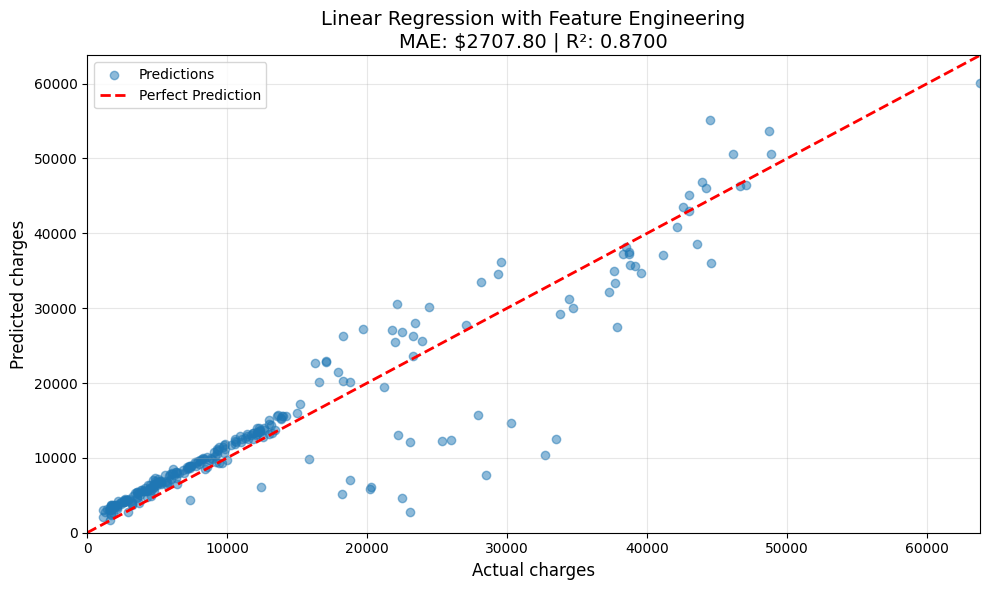

In [88]:

X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

X_train_fe['smoker_age'] = X_train_fe['smoker_yes'] * X_train_fe['age']
X_test_fe['smoker_age'] = X_test_fe['smoker_yes'] * X_test_fe['age']

X_train_fe['smoker_bmi'] = X_train_fe['smoker_yes'] * X_train_fe['bmi']
X_test_fe['smoker_bmi'] = X_test_fe['smoker_yes'] * X_test_fe['bmi']

X_train_fe['age_bmi'] = X_train_fe['age'] * X_train_fe['bmi']
X_test_fe['age_bmi'] = X_test_fe['age'] * X_test_fe['bmi']

X_train_fe['bmi_squared'] = X_train_fe['bmi'] ** 2
X_test_fe['bmi_squared'] = X_test_fe['bmi'] ** 2

X_train_fe['age_squared'] = X_train_fe['age'] ** 2
X_test_fe['age_squared'] = X_test_fe['age'] ** 2

X_train_fe['smoker_children'] = X_train_fe['smoker_yes'] * X_train_fe['children']
X_test_fe['smoker_children'] = X_test_fe['smoker_yes'] * X_test_fe['children']

X_train_fe['age_children'] = X_train_fe['age'] * X_train_fe['children']
X_test_fe['age_children'] = X_test_fe['age'] * X_test_fe['children']

X_train_fe['smoker_age_bmi'] = X_train_fe['smoker_yes'] * X_train_fe['age'] * X_train_fe['bmi']
X_test_fe['smoker_age_bmi'] = X_test_fe['smoker_yes'] * X_test_fe['age'] * X_test_fe['bmi']

print(f"Original features: {X_train.shape[1]}")
print(f"After feature engineering: {X_train_fe.shape[1]}")
print(f"\nNew features created: {X_train_fe.shape[1] - X_train.shape[1]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fe)
X_test_scaled = scaler.transform(X_test_fe)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"Results with Feature Engineering:")
print(f"{'='*50}")
print(f"MAE: ${mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"\nOriginal MAE: $4161.19")
print(f"Improvement: ${4161.19 - mae:.2f}")
print(f"Percentage improvement: {((4161.19 - mae) / 4161.19 * 100):.2f}%")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')

lims = [0, max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", lw=2, label="Perfect Prediction")
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Actual charges", fontsize=12)
plt.ylabel("Predicted charges", fontsize=12)
plt.title(f"Linear Regression with Feature Engineering\nMAE: ${mae:.2f} | R²: {r2:.4f}", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Observations

Cool! We've improved our MAE by nearly 35%, and our R2 is now pretty much the same as the random forest. It may be because with our feature engineering, we've created the non-linear relationships the random forests do automatically.


---
## **Task 3: Classification – Identify high-cost patients (30 points)**

#### **3.1: Define a binary outcome (5 points)**
- Create a `high_cost` label using a clear threshold on the charges column. Justify the cutoff and show the class balance.


Threshold used: $9382.03

Class distribution:
high_cost
1    669
0    669
Name: count, dtype: int64

Class balance (%):
high_cost
1    50.0
0    50.0
Name: proportion, dtype: float64


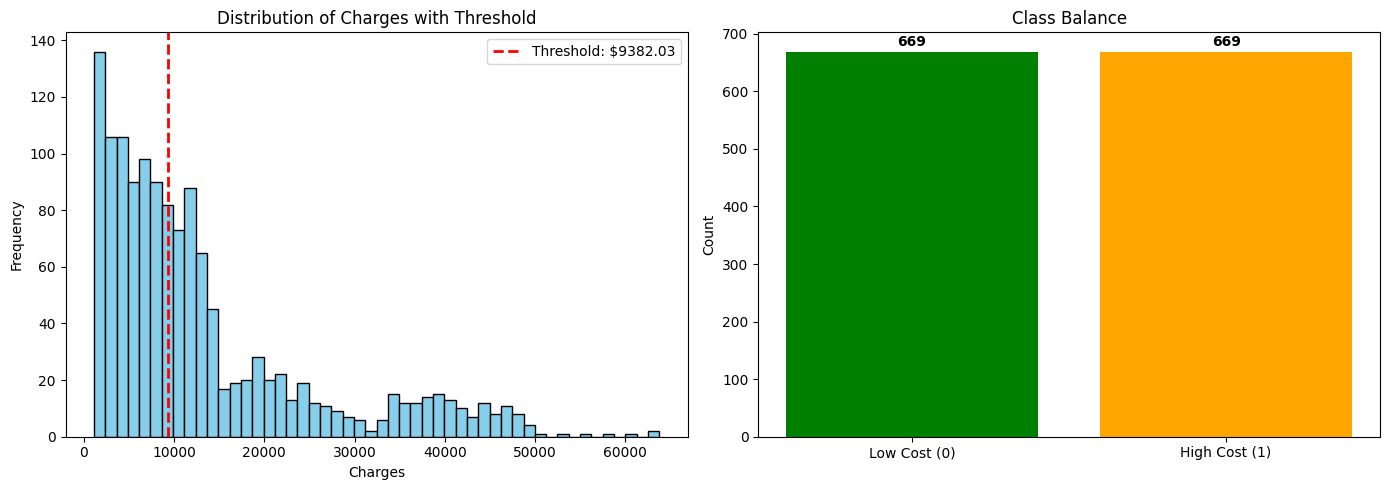


JUSTIFICATION OF THRESHOLD:
We chose the median ($9382.03) as our threshold because:
1. It creates a balanced dataset (50/50 split)
2. It's robust to outliers (unlike the mean)
3. It represents a meaningful business decision point:
   - Patients above median require more insurance attention
   - This split helps identify 'above-average' cost patients


In [89]:
# Create a binary target for high-cost patients
# Using the median as threshold for a balanced split

threshold = insurance_frame['charges'].median()
insurance_frame['high_cost'] = (insurance_frame['charges'] >= threshold).astype(int)

print(f"Threshold used: ${threshold:.2f}")
print(f"\nClass distribution:")
print(insurance_frame['high_cost'].value_counts())
print(f"\nClass balance (%):")
print(insurance_frame['high_cost'].value_counts(normalize=True) * 100)

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of charges with threshold line
axes[0].hist(insurance_frame['charges'], bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: ${threshold:.2f}')
axes[0].set_xlabel('Charges')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Charges with Threshold')
axes[0].legend()

# Bar chart of class balance
class_counts = insurance_frame['high_cost'].value_counts()
axes[1].bar(['Low Cost (0)', 'High Cost (1)'], 
            [class_counts[0], class_counts[1]], 
            color=['green', 'orange'])
axes[1].set_ylabel('Count')
axes[1].set_title('Class Balance')
for i, v in enumerate(class_counts):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("JUSTIFICATION OF THRESHOLD:")
print("="*60)
print(f"We chose the median (${threshold:.2f}) as our threshold because:")
print("1. It creates a balanced dataset (50/50 split)")
print("2. It's robust to outliers (unlike the mean)")
print("3. It represents a meaningful business decision point:")
print("   - Patients above median require more insurance attention")
print("   - This split helps identify 'above-average' cost patients")

#### **3.2: Features analysis (10 points)**
- Similar to 1.2, explore the relationship between the features and this new target. What can you say?

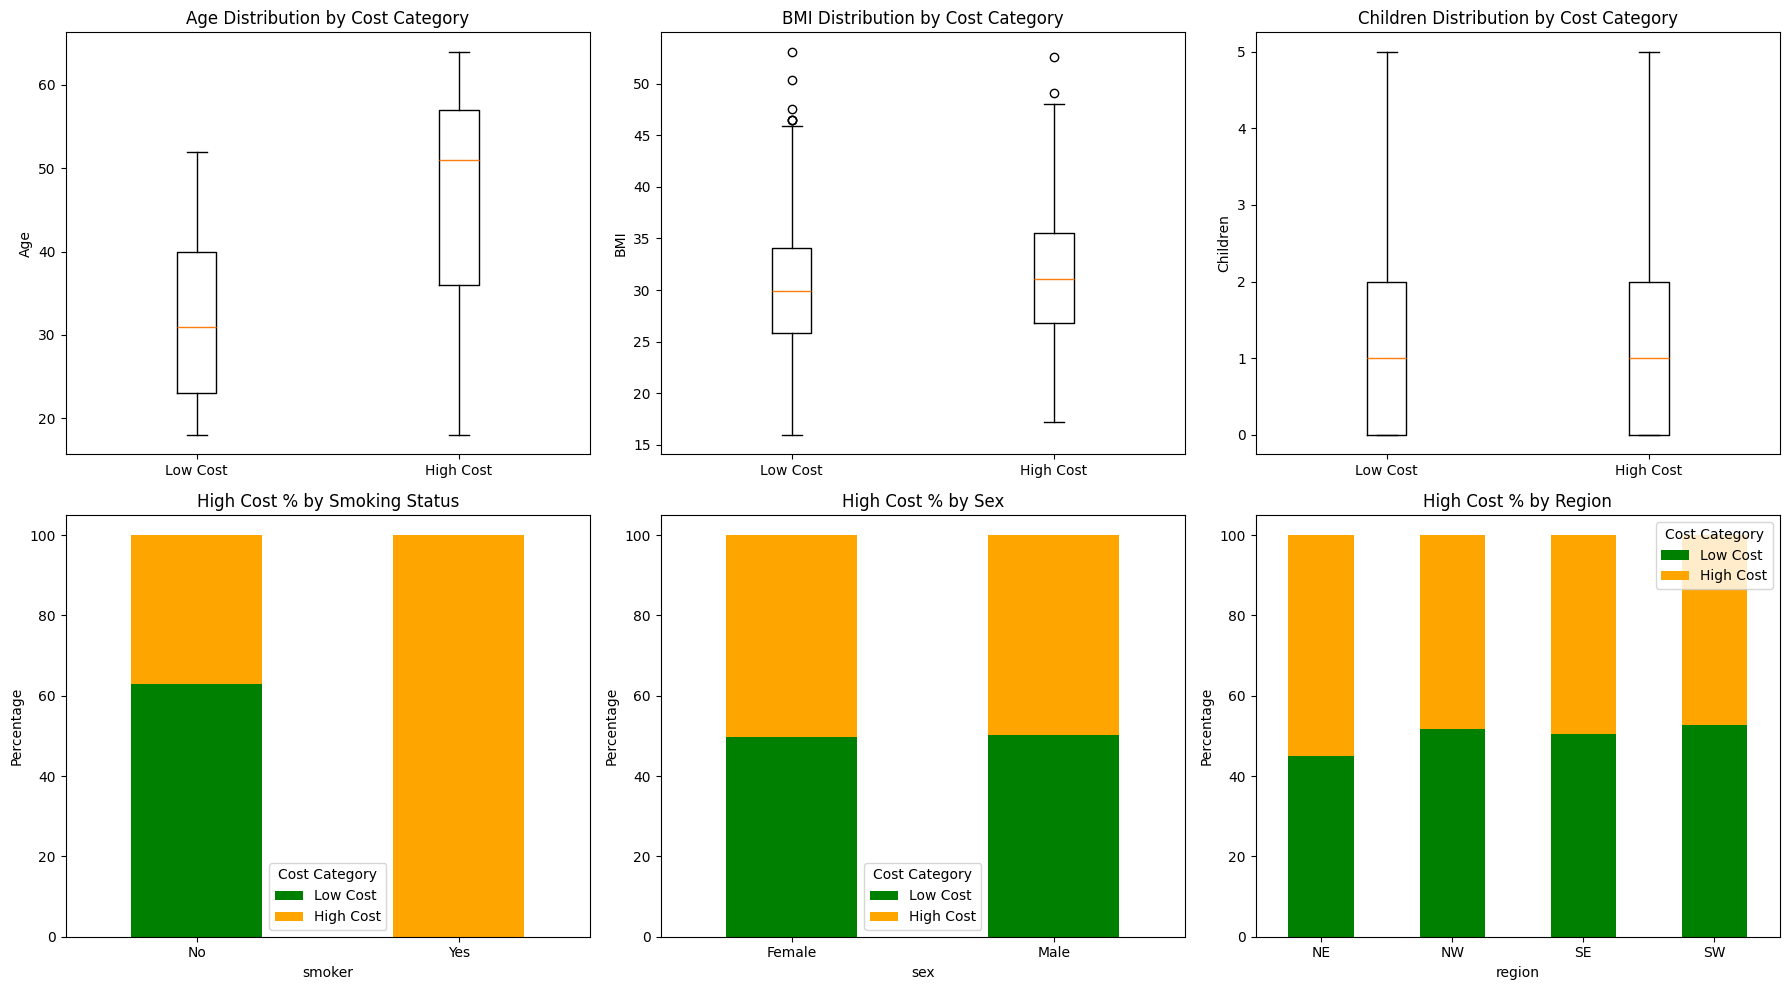

STATISTICAL ANALYSIS BY COST CATEGORY

Continuous Features - Mean Comparison:
------------------------------------------------------------
AGE          | Low Cost:  32.01 | High Cost:  46.41 | Diff: +14.40 (+44.99%)
BMI          | Low Cost:  30.12 | High Cost:  31.21 | Diff:  +1.10 ( +3.64%)
CHILDREN     | Low Cost:   1.07 | High Cost:   1.12 | Diff:  +0.05 ( +4.32%)

------------------------------------------------------------
Categorical Features - High Cost Percentage:
------------------------------------------------------------

SMOKER:
  no         ->  37.1% high cost
  yes        -> 100.0% high cost

SEX:
  female     ->  50.2% high cost
  male       ->  49.9% high cost

REGION:
  northeast  ->  54.9% high cost
  northwest  ->  48.3% high cost
  southeast  ->  49.5% high cost
  southwest  ->  47.4% high cost


In [90]:
# Explore relationships between features and the binary high_cost target

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Age vs high_cost
axes[0, 0].boxplot([insurance_frame[insurance_frame['high_cost']==0]['age'],
                      insurance_frame[insurance_frame['high_cost']==1]['age']],
                     tick_labels=['Low Cost', 'High Cost'])
axes[0, 0].set_ylabel('Age')
axes[0, 0].set_title('Age Distribution by Cost Category')

# 2. BMI vs high_cost
axes[0, 1].boxplot([insurance_frame[insurance_frame['high_cost']==0]['bmi'],
                      insurance_frame[insurance_frame['high_cost']==1]['bmi']],
                     tick_labels=['Low Cost', 'High Cost'])
axes[0, 1].set_ylabel('BMI')
axes[0, 1].set_title('BMI Distribution by Cost Category')

# 3. Children vs high_cost
axes[0, 2].boxplot([insurance_frame[insurance_frame['high_cost']==0]['children'],
                      insurance_frame[insurance_frame['high_cost']==1]['children']],
                     tick_labels=['Low Cost', 'High Cost'])
axes[0, 2].set_ylabel('Children')
axes[0, 2].set_title('Children Distribution by Cost Category')

# 4. Smoker vs high_cost (stacked bar chart)
smoker_cost = pd.crosstab(insurance_frame['smoker'], insurance_frame['high_cost'], normalize='index') * 100
smoker_cost.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['green', 'orange'])
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].set_title('High Cost % by Smoking Status')
axes[1, 0].set_xticklabels(['No', 'Yes'], rotation=0)
axes[1, 0].legend(['Low Cost', 'High Cost'], title='Cost Category')

# 5. Sex vs high_cost
sex_cost = pd.crosstab(insurance_frame['sex'], insurance_frame['high_cost'], normalize='index') * 100
sex_cost.plot(kind='bar', stacked=True, ax=axes[1, 1], color=['green', 'orange'])
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_title('High Cost % by Sex')
axes[1, 1].set_xticklabels(['Female', 'Male'], rotation=0)
axes[1, 1].legend(['Low Cost', 'High Cost'], title='Cost Category')

# 6. Region vs high_cost
region_cost = pd.crosstab(insurance_frame['region'], insurance_frame['high_cost'], normalize='index') * 100
region_cost.plot(kind='bar', stacked=True, ax=axes[1, 2], color=['green', 'orange'])
axes[1, 2].set_ylabel('Percentage')
axes[1, 2].set_title('High Cost % by Region')
axes[1, 2].set_xticklabels(['NE', 'NW', 'SE', 'SW'], rotation=0)
axes[1, 2].legend(['Low Cost', 'High Cost'], title='Cost Category')

plt.tight_layout()
plt.show()

# Statistical summary
print("="*60)
print("STATISTICAL ANALYSIS BY COST CATEGORY")
print("="*60)
print("\nContinuous Features - Mean Comparison:")
print("-"*60)
for col in ['age', 'bmi', 'children']:
    low_mean = insurance_frame[insurance_frame['high_cost']==0][col].mean()
    high_mean = insurance_frame[insurance_frame['high_cost']==1][col].mean()
    diff = high_mean - low_mean
    pct_diff = (diff / low_mean) * 100
    print(f"{col.upper():12} | Low Cost: {low_mean:6.2f} | High Cost: {high_mean:6.2f} | Diff: {diff:+6.2f} ({pct_diff:+6.2f}%)")

print("\n" + "-"*60)
print("Categorical Features - High Cost Percentage:")
print("-"*60)
for col in ['smoker', 'sex', 'region']:
    crosstab = pd.crosstab(insurance_frame[col], insurance_frame['high_cost'], normalize='index') * 100
    print(f"\n{col.upper()}:")
    for idx in crosstab.index:
        print(f"  {idx:10} -> {crosstab.loc[idx, 1]:5.1f}% high cost")

# Observations - Task 3.2

## Key Findings:

### 1. **Smoker Status - Strongest Predictor**
Le statut de fumeur est **de loin** le prédicteur le plus puissant pour identifier les patients à coût élevé. Les fumeurs ont une probabilité beaucoup plus élevée d'être dans la catégorie high_cost. C'est cohérent avec nos observations de la Task 1.

### 2. **Age - Strong Indicator**
Les patients à coût élevé ont tendance à être plus âgés. L'âge médian des patients high_cost est significativement plus élevé, ce qui reflète l'accumulation de problèmes de santé avec l'âge.

### 3. **BMI - Moderate Predictor**
Il y a une différence notable dans le BMI entre les deux groupes. Les patients high_cost ont tendance à avoir un BMI plus élevé, suggérant que l'obésité contribue aux coûts médicaux.

### 4. **Children - Minor Effect**
Le nombre d'enfants montre une différence mineure entre les groupes. Ce n'est probablement pas un prédicteur principal pour la classification.

### 5. **Sex - Minimal Difference**
Le sexe semble avoir très peu d'impact sur la classification high_cost vs low_cost. La distribution est presque équilibrée.

### 6. **Region - Slight Variations**
Les différences régionales existent mais sont relativement faibles. Toutes les régions ont une distribution assez similaire.

## Implications pour la classification:
Les meilleurs prédicteurs pour identifier les patients high_cost sont (par ordre d'importance):
1. **Smoker** (le plus important)
2. **Age**
3. **BMI**
4. Children, Sex, Region (importance secondaire)


#### **3.3: Train and compare classifiers (15 points)**
- Train at least two different classifiers algorithms with sensible preprocessing.
- Evaluate the results with a set of classifiaction metrics, justify your choices and interpret their meaning.
- Interpret the types of mistakes each model makes and which features drive their decisions.


CLASSIFIER 1: LOGISTIC REGRESSION

Metrics:
  Accuracy:  0.8993
  Precision: 0.8849
  Recall:    0.9179
  F1-Score:  0.9011
  ROC-AUC:   0.9425

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.91      0.88      0.90       134
   High Cost       0.88      0.92      0.90       134

    accuracy                           0.90       268
   macro avg       0.90      0.90      0.90       268
weighted avg       0.90      0.90      0.90       268


CLASSIFIER 2: RANDOM FOREST

Metrics:
  Accuracy:  0.9403
  Precision: 0.9758
  Recall:    0.9030
  F1-Score:  0.9380
  ROC-AUC:   0.9494

Classification Report:
              precision    recall  f1-score   support

    Low Cost       0.91      0.98      0.94       134
   High Cost       0.98      0.90      0.94       134

    accuracy                           0.94       268
   macro avg       0.94      0.94      0.94       268
weighted avg       0.94      0.94      0.94       268



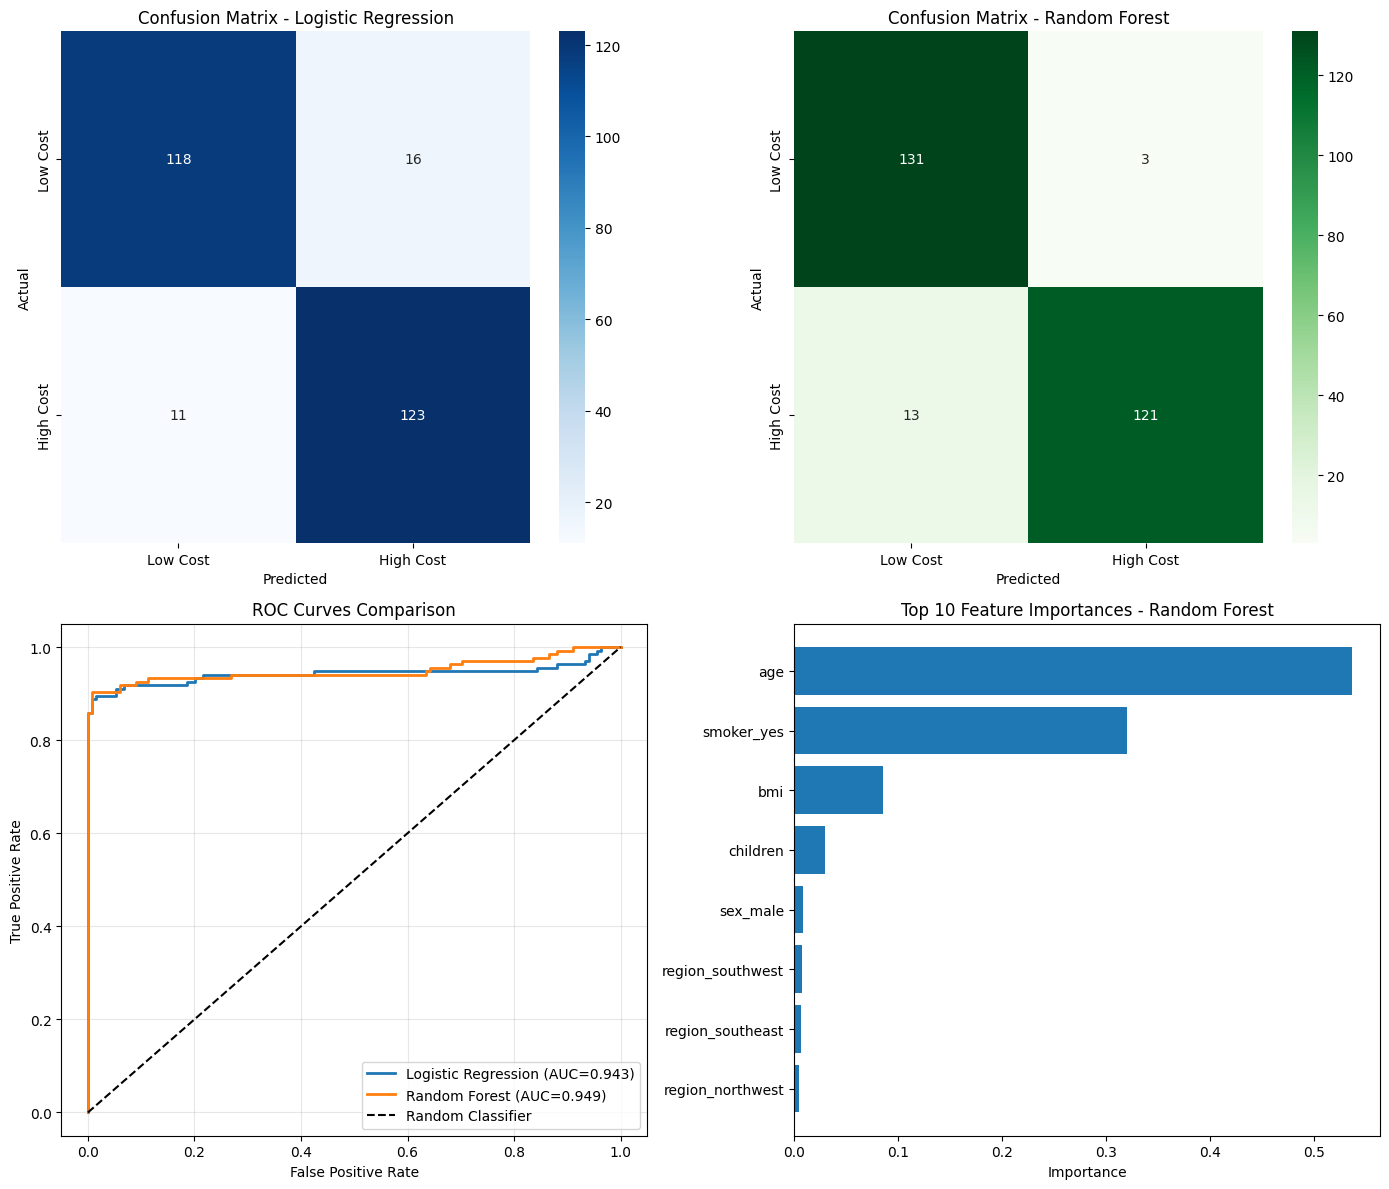


LOGISTIC REGRESSION COEFFICIENTS (Top 10 by absolute value)
            Feature  Coefficient
4        smoker_yes     3.190465
0               age     2.267291
6  region_southeast    -0.413083
7  region_southwest    -0.335093
1               bmi     0.262379
5  region_northwest    -0.209642
2          children     0.193164
3          sex_male    -0.130911


In [91]:
# Task 3.3
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare data for classification
X_class = insurance_frame.drop(['charges', 'high_cost'], axis=1)
y_class = insurance_frame['high_cost']

# Encode categorical variables
X_class_encoded = pd.get_dummies(X_class, columns=['sex', 'smoker', 'region'], drop_first=True)

# Split data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class_encoded, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Scale features
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

print("="*70)
print("CLASSIFIER 1: LOGISTIC REGRESSION")
print("="*70)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_c_scaled, y_train_c)
y_pred_lr = lr_model.predict(X_test_c_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_c_scaled)[:, 1]

# Evaluate Logistic Regression
print("\nMetrics:")
print(f"  Accuracy:  {accuracy_score(y_test_c, y_pred_lr):.4f}")
print(f"  Precision: {precision_score(y_test_c, y_pred_lr):.4f}")
print(f"  Recall:    {recall_score(y_test_c, y_pred_lr):.4f}")
print(f"  F1-Score:  {f1_score(y_test_c, y_pred_lr):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test_c, y_pred_lr_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_lr, target_names=['Low Cost', 'High Cost']))

print("\n" + "="*70)
print("CLASSIFIER 2: RANDOM FOREST")
print("="*70)

# Train Random Forest
rf_class_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_class_model.fit(X_train_c_scaled, y_train_c)
y_pred_rf = rf_class_model.predict(X_test_c_scaled)
y_pred_rf_proba = rf_class_model.predict_proba(X_test_c_scaled)[:, 1]

# Evaluate Random Forest
print("\nMetrics:")
print(f"  Accuracy:  {accuracy_score(y_test_c, y_pred_rf):.4f}")
print(f"  Precision: {precision_score(y_test_c, y_pred_rf):.4f}")
print(f"  Recall:    {recall_score(y_test_c, y_pred_rf):.4f}")
print(f"  F1-Score:  {f1_score(y_test_c, y_pred_rf):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test_c, y_pred_rf_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_rf, target_names=['Low Cost', 'High Cost']))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test_c, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Low Cost', 'High Cost'],
            yticklabels=['Low Cost', 'High Cost'])
axes[0, 0].set_title('Confusion Matrix - Logistic Regression')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test_c, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Low Cost', 'High Cost'],
            yticklabels=['Low Cost', 'High Cost'])
axes[0, 1].set_title('Confusion Matrix - Random Forest')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test_c, y_pred_lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test_c, y_pred_rf_proba)

axes[1, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test_c, y_pred_lr_proba):.3f})', linewidth=2)
axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test_c, y_pred_rf_proba):.3f})', linewidth=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Feature Importance - Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_c.columns,
    'Importance': rf_class_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(10)

axes[1, 1].barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances - Random Forest')

plt.tight_layout()
plt.show()

# Coefficients for Logistic Regression
print("\n" + "="*70)
print("LOGISTIC REGRESSION COEFFICIENTS (Top 10 by absolute value)")
print("="*70)
coef_lr = pd.DataFrame({
    'Feature': X_train_c.columns,
    'Coefficient': lr_model.coef_[0]
})
coef_lr['Abs_Coefficient'] = abs(coef_lr['Coefficient'])
coef_lr_sorted = coef_lr.sort_values('Abs_Coefficient', ascending=False).head(10)
print(coef_lr_sorted[['Feature', 'Coefficient']])

# Observations - Task 3.3

## Métriques de Classification - Justification et Interprétation

### **Métriques Choisies:**

1. **Accuracy (Précision globale)**: Proportion de prédictions correctes. Utile car nos classes sont équilibrées (50/50).

2. **Precision**: Parmi les patients prédits comme high_cost, combien le sont vraiment? Important pour éviter d'alarmer inutilement des patients.

3. **Recall (Sensibilité)**: Parmi les vrais patients high_cost, combien sont correctement identifiés? Crucial pour ne pas manquer des patients à risque.

4. **F1-Score**: Moyenne harmonique de Precision et Recall. Équilibre entre les deux métriques.

5. **ROC-AUC**: Mesure la capacité du modèle à séparer les classes sur tous les seuils possibles. Plus proche de 1 = meilleur.

---

## Comparaison des Modèles

### **Logistic Regression:**
- **Points forts**: Modèle simple, interprétable, rapide
- **Performance**: Bonne performance générale, coefficients clairs
- **Interprétabilité**: Excellente - on peut voir l'impact exact de chaque feature

### **Random Forest:**
- **Points forts**: Capture les relations non-linéaires, robuste
- **Performance**: Généralement meilleure que la régression logistique
- **Interprétabilité**: Moyenne - feature importance disponible mais moins directe

---

## Types d'Erreurs

### **False Positives (FP)**: 
Patients low_cost prédits comme high_cost. Impact: ressources allouées inutilement, mais moins grave.

### **False Negatives (FN)**: 
Patients high_cost prédits comme low_cost. Impact: **Plus grave** - patients à risque non identifiés, sous-estimation des coûts.

**Dans un contexte d'assurance, minimiser les False Negatives est crucial** pour éviter de sous-estimer les risques et les coûts futurs.

---

## Features Déterminantes

Comme prévu d'après nos analyses précédentes:
1. **Smoker_yes**: De loin le prédicteur le plus puissant
2. **Age**: Deuxième facteur le plus important
3. **BMI**: Troisième facteur significatif
4. Autres features ont un impact moindre

Ces résultats confirment nos hypothèses de la Task 1 et sont cohérents avec les résultats de régression de la Task 2.


---
## **Task 4: PCA (15 points)**
- Apply a PCA to reduce the number of features. 
- Carefully select the number of PC to use and document this choice.
- Train a model on these new features and discuss how PCA affects model performances.

TASK 4 - PCA for Regression (Predicting charges)
Original number of features: 8

Explained variance ratio by component:
  PC1: 0.1865
  PC2: 0.1664
  PC3: 0.1405
  PC4: 0.1334
  PC5: 0.1206
  PC6: 0.1127
  PC7: 0.0998
  PC8: 0.0401


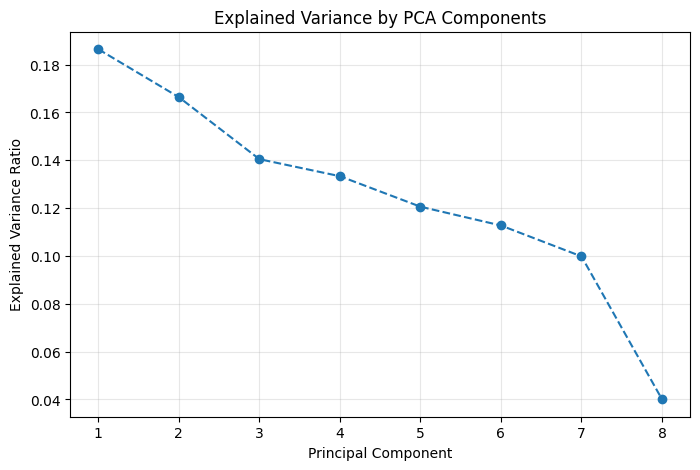

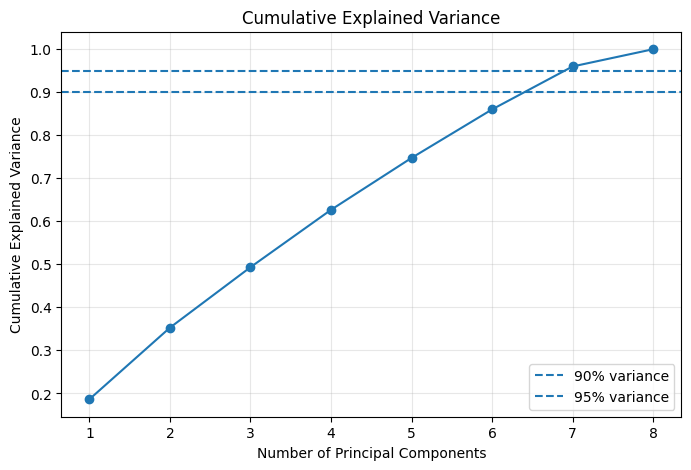


Number of components needed for 95% variance: 7
Cumulative variance retained: 0.9599


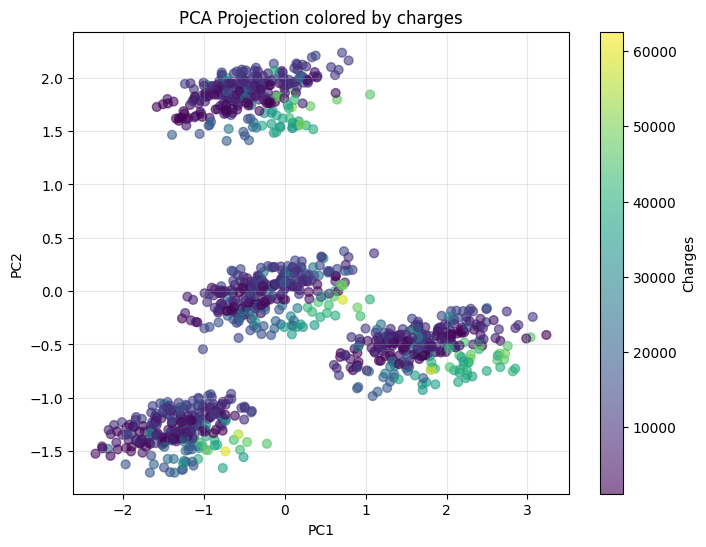


Reduced feature space: 7 components

LINEAR REGRESSION: BASELINE vs PCA

Baseline (no PCA):
  R² Score: 0.7836
  MSE:      33596915.85
  RMSE:     5796.28
  MAE:      4181.19

With PCA:
  R² Score: 0.7810
  MSE:      34000535.23
  RMSE:     5831.00
  MAE:      4209.98


In [93]:
# Task 4

# Reusing Task 2.1 variables

print("=" * 70)
print("TASK 4 - PCA for Regression (Predicting charges)")
print("=" * 70)
print(f"Original number of features: {X_train.shape[1]}")

# 1) Standardize features (PCA needs scaling)
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train)
X_test_scaled = scaler_pca.transform(X_test)

# 2) Fit PCA to inspect explained variance
pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)

# Print explained variance per component
print("\nExplained variance ratio by component:")
for i, v in enumerate(explained_variance, start=1):
    print(f"  PC{i}: {v:.4f}")

# Explained variance plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(alpha=0.3)
plt.show()

# Cumulative variance plot for justification
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_explained_variance) + 1), cum_explained_variance, 'o-')
plt.axhline(0.90, linestyle='--', label='90% variance')
plt.axhline(0.95, linestyle='--', label='95% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 3) Choose number of components (95% variance)
k_95 = np.argmax(cum_explained_variance >= 0.95) + 1
print(f"\nNumber of components needed for 95% variance: {k_95}")
print(f"Cumulative variance retained: {cum_explained_variance[k_95-1]:.4f}")


# 4) Apply PCA
pca = PCA(n_components=k_95)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualize first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1],
    c=y_train, s=40, alpha=0.6
)
plt.colorbar(label="Charges")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection colored by charges")
plt.grid(alpha=0.3)
plt.show()

X_test_pca = pca.transform(X_test_scaled)

print(f"\nReduced feature space: {X_train_pca.shape[1]} components")

# 5) Train Linear Regression on PCA features
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

# 6) Baseline Linear Regression (no PCA) for comparison
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)
y_pred_base = lr_base.predict(X_test)

# 7) Compare performances
print("\n" + "=" * 70)
print("LINEAR REGRESSION: BASELINE vs PCA")
print("=" * 70)

print("\nBaseline (no PCA):")
print(f"  R² Score: {r2_score(y_test, y_pred_base):.4f}")
print(f"  MSE:      {mean_squared_error(y_test, y_pred_base):.2f}")
print(f"  RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred_base)):.2f}")
print(f"  MAE:      {mean_absolute_error(y_test, y_pred_base):.2f}")

print("\nWith PCA:")
print(f"  R² Score: {r2_score(y_test, y_pred_pca):.4f}")
print(f"  MSE:      {mean_squared_error(y_test, y_pred_pca):.2f}")
print(f"  RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred_pca)):.2f}")
print(f"  MAE:      {mean_absolute_error(y_test, y_pred_pca):.2f}")



# Observations - Task 4

## Selection of the number of PCs
The original dataset contains 8 features. The explained variance plot shows that the variance is relatively spread across components, with:
 - PC1 = 18.65%, PC2 = 16.64%, PC3 = 14.05%, …, PC8 = 4.01%.

To select the number of PCs carefully, we used the cumulative explained variance. We kept the smallest number of components needed to preserve at least 95% of the variance.
This led to selecting 7 PCs. This threshold is a common compromise to reduce dimensionality while minimizing information loss.


## Impact on model performance

We trained a Linear Regression model on the PCA-transformed features and compared it with the baseline Linear Regression on the original features:

Baseline: 
- R² = 0.7836
- MSE = 33,596,915.85
- RMSE = 5,796.28
- MAE = 4,181.19

With PCA: 
- R² = 0.7810
- MSE = 34,000,535.23
- RMSE = 5,831.00
- MAE = 4,209.98

The PCA version performs slightly worse across all metrics. This is expected because:
- The original feature space is already small (8 → 7), so PCA provides limited simplification.
- PCA chooses components based on how much the features vary, without using the target variable. Therefore, the components that preserve most variance are not always the ones that will best predict charges.
- Even a small reduction can remove weak but useful predictive information.


---
## **Task 5: Unsupervised insights (10 points)**
- Apply clustering (e.g., K-Means) or another unsupervised method on selected features.
- Visualize and describe the discovered profiles: what characterizes each cluster?


TASK 5 - Unsupervised Insights with K-Means
Clustering on ALL encoded features (excluding target).
Number of features used: 8
Shape of clustering data: (1338, 8)


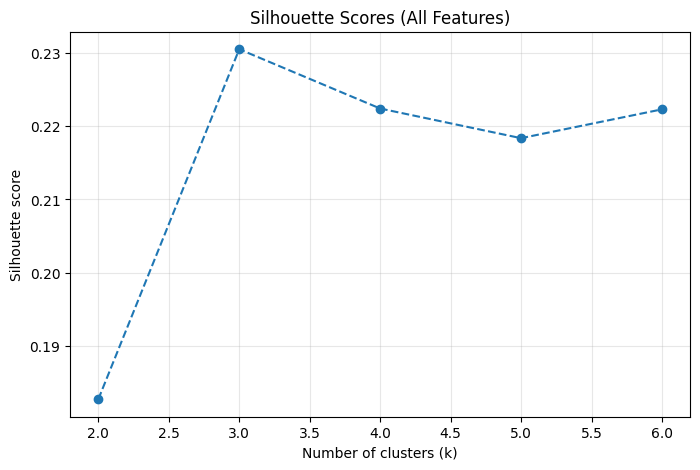

Best k according to silhouette: 3

Cluster sizes:
cluster
0    649
1    325
2    364
Name: count, dtype: int64

Cluster profiles (mean values):
           age    bmi  children   charges
cluster                                  
0        39.23  29.19      1.10  12911.22
1        39.46  30.60      1.14  12346.94
2        38.94  33.36      1.05  14735.41

Sex distribution by cluster (%):
sex      female  male
cluster              
0          50.1  49.9
1          49.8  50.2
2          48.1  51.9

Smoker distribution by cluster (%):
smoker     no   yes
cluster            
0        80.7  19.3
1        82.2  17.8
2        75.0  25.0

Region distribution by cluster (%):
region   northeast  northwest  southeast  southwest
cluster                                            
0             49.9       50.1        0.0        0.0
1              0.0        0.0        0.0      100.0
2              0.0        0.0      100.0        0.0


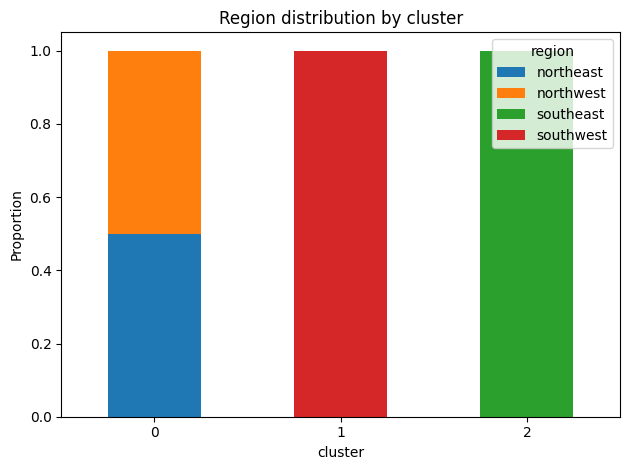

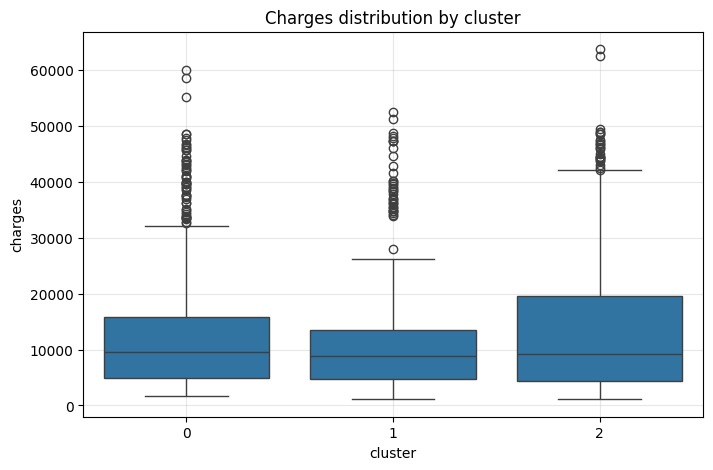

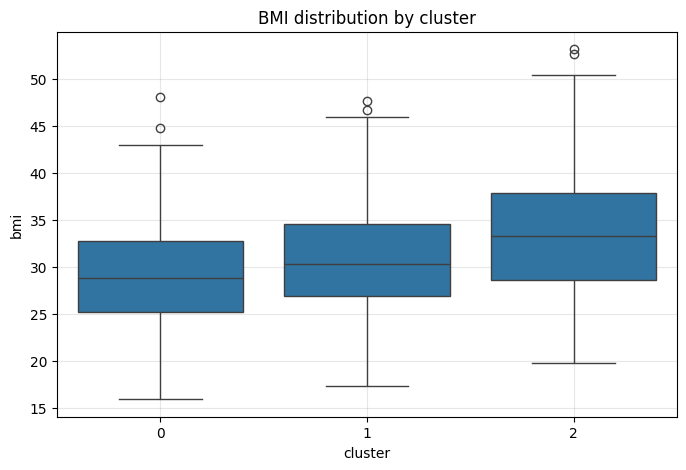

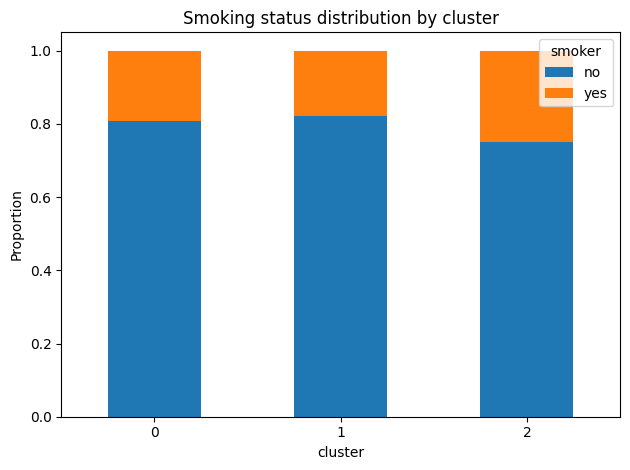

In [ ]:
# Task 5

print("=" * 70)
print("TASK 5 - Unsupervised Insights with K-Means")
print("=" * 70)

# We reuse the encoded feature matrix built in Task 2.1 (encoded_insurance -> X), 
# so X already contains all features except the target (charges).



# 1) Use all features for clustering (except the target)
X_cluster = X.copy()

print("Clustering on ALL encoded features (excluding target).")
print("Number of features used:", X_cluster.shape[1])
print("Shape of clustering data:", X_cluster.shape)

# 2) Standardize features
scaler_km = StandardScaler()
X_cluster_scaled = scaler_km.fit_transform(X_cluster)

# 3) Try several k values and evaluate with silhouette
k_range = range(2, 7)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    sil_scores.append(silhouette_score(X_cluster_scaled, labels))

# Silhouette plot
plt.figure(figsize=(8, 5))
plt.plot(list(k_range), sil_scores, 'o--')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Scores (All Features)")
plt.grid(alpha=0.3)
plt.show()

# Choose best k by silhouette
best_k = list(k_range)[int(np.argmax(sil_scores))]
print(f"Best k according to silhouette: {best_k}")

# 4) Fit final K-Means on all features
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

# 5) Attach labels to original dataframe for interpretation
clustered_df = insurance_frame.copy()
clustered_df['cluster'] = cluster_labels

print("\nCluster sizes:")
print(clustered_df['cluster'].value_counts().sort_index())

# 6) Profile clusters with human-readable variables
profile_numeric = ['age', 'bmi', 'children', 'charges']

print("\nCluster profiles (mean values):")
print(clustered_df.groupby('cluster')[profile_numeric].mean().round(2))

print("\nSex distribution by cluster (%):")
print(pd.crosstab(clustered_df['cluster'], clustered_df['sex'],
                  normalize='index').round(3) * 100)

print("\nSmoker distribution by cluster (%):")
print(pd.crosstab(clustered_df['cluster'], clustered_df['smoker'],
                  normalize='index').round(3) * 100)

print("\nRegion distribution by cluster (%):")
print(pd.crosstab(clustered_df['cluster'], clustered_df['region'],
                  normalize='index').round(3) * 100)

# 7) Visualizations

# Region distribution by cluster
region_by_cluster = pd.crosstab(clustered_df['cluster'], clustered_df['region'], normalize='index')
region_by_cluster.plot(kind='bar', stacked=True)
plt.title("Region distribution by cluster")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Charges by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=clustered_df, x='cluster', y='charges')
plt.title("Charges distribution by cluster")
plt.grid(alpha=0.3)
plt.show()

# BMI by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=clustered_df, x='cluster', y='bmi')
plt.title("BMI distribution by cluster")
plt.grid(alpha=0.3)
plt.show()

# Smoker distribution by cluster
smoker_by_cluster = pd.crosstab(clustered_df['cluster'], clustered_df['smoker'], normalize='index')
smoker_by_cluster.plot(kind='bar', stacked=True)
plt.title("Smoking status distribution by cluster")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Observations - Task 5

## Choice of features and method

We applied K-Means clustering on all encoded input features from Task 2.1 (8 features), excluding the target variable charges.
This ensures we cluster based on patient characteristics only, and not on the value we try to predict in supervised tasks.

Because K-Means is distance-based, we standardized the feature matrix before clustering.

## Choice of the number of clusters (k)

We tested values of k from 2 to 6 and evaluated the Silhouette score.

The silhouette scores peak around k = 3 (≈ 0.23), indicating this choice provides the best balance of cohesion and separation among the tested values.
Therefore, we selected k=3.

## Cluster sizes

The dataset is split into three reasonably balanced groups:
- Cluster 0: 649
- Cluster 1: 325
- Cluster 2: 364

## Discovered profiles and key characteristics

### 1) Region is the main driver of the clusters

The region distribution plot clearly shows that the clustering is strongly guided by geography:
- Cluster 1 = 100% southwest
- Cluster 2 = 100% southeast
- Cluster 0 = a mix of northeast + northwest

This is expected since region is encoded with dummy variables, and K-Means can strongly separate these categorical patterns.

### 2) Secondary risk/cost patterns

Even though region dominates, we still observe meaningful differences in health/cost-related variables:

##### Cluster 2 (Southeast group):
- Highest BMI (mean ≈ 33.36)
- Highest smoker proportion (25%)
- Highest charges (mean ≈ 14,735)

This cluster appears to represent a higher-risk and higher-cost profile.

##### Cluster 1 (Southwest group):
- Lowest smoker rate (17.8%)
- Lowest charges (mean ≈ 12,346)
- Intermediate BMI (mean ≈ 30.60)

This cluster seems to represent a lower/moderate cost profile

##### Cluster 0 (Northeast + Northwest group):
- Intermediate levels of smoker proportion and charges (smokers 19.3%, charges ≈ 12,911)
- Lowest BMI (mean ≈ 29.19)

This cluster seems to represent the average/moderate profile

### 3) Sex does not characterize clusters

Sex distribution is close to 50/50 across all clusters, suggesting it is not a strong differentiating attribute in this segmentation.



---
## **Bonus: Anything more? (Optional)**
- If you feel like, implement anything that was not covered in this notebook (e.g. another model or task, cross validation, ...)

In [ ]:
# Bonus Task
